# Práctica del módulo NLP

Importo los paquetes necesarios

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re
from collections import Counter

from spacy.lang.es.stop_words import STOP_WORDS

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim

Cargo los datos y le asigno un topic a cada dataset

In [2]:
aiv5 = pd.read_csv("Amazon_Instant_Video_5.csv")  # Topic 1
a5 = pd.read_csv("Automotive_5.csv")              # Topic 2
dm5 = pd.read_csv("Digital_Music_5.csv")          # Topic 3
mi5 = pd.read_csv("Musical_Instruments_5.csv")    # Topic 4
plg5 = pd.read_csv("Patio_Lawn_and_Garden_5.csv") # Topic 5

In [3]:
aiv5["topic"] = 1
a5["topic"] = 2
dm5["topic"] = 3
mi5["topic"] = 4
plg5["topic"] = 5

Mezclo y remuevo todos mis datos

In [4]:
reviews = pd.concat([aiv5,a5,dm5,mi5,plg5], ignore_index=True).dropna(subset=['reviewText']).sample(frac=1)

In [5]:
reviews

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,topic
18579,A2BGDV09HCHX8E,B000FCRS0I,"msb175 ""msb""","[0, 0]",This is one of those items that you keep for '...,4,Something extra,1402617600,"06 13, 2014",2
14240,A1Y3YM1XM3N71S,B0047RKS72,"Shawn D ""s1283""","[0, 0]","These fit all 194 bulb applications, and for c...",5,Low profile,1377907200,"08 31, 2013",2
33914,A6OLPMJ9HH4IP,B003DVGVIS,"M. C. Malkemus ""MS""","[0, 0]","I ordered them because they are carbon fiber, ...",5,The Bomb of picks (IMHO),1389312000,"01 10, 2014",4
37905,A3HMFQWM9Q21SD,B0009RLE5Y,Paul D Ford,"[0, 0]",I use this boom attached to a desk clamp to ho...,5,"Very solidly built, great locking clutch, grea...",1327190400,"01 22, 2012",4
24208,A62G4QX6XQVLP,B0000024SN,Anyechka,"[4, 9]",The songs on this album are really soft and lo...,4,A pretty-sounding sophomore album,1090972800,"07 28, 2004",3
...,...,...,...,...,...,...,...,...,...,...
32094,A310MXGFV4RIK0,B0002CZW0Y,"Wayne Stewart ""Aha! Maven""","[0, 0]",Well thought out unit that does what it says i...,5,Great POP Filter!,1355702400,"12 17, 2012",4
29835,A1LG11VGFDAFY,B003WTE886,Charlie Edwards,"[0, 0]",When Taylor Swift announced her new album in m...,4,She topped Fearless,1353024000,"11 16, 2012",3
6200,A2YDSN72HU0KPR,B00CDBQ9B8,"Theresa Lepiane ""Theresa""","[0, 0]",Very funny. If you have ever watched or read ...,5,Awesome funny,1366416000,"04 20, 2013",1
40049,A33JTFRM6S378Q,B00004R9TL,Butterworth,"[0, 0]","For years, I lived with a Black & Decker trimm...",5,Almost as Good as Sliced Bread,1356998400,"01 1, 2013",5


In [6]:
reviews.topic.value_counts()

3    10000
1    10000
2     9997
4     9993
5     9991
Name: topic, dtype: int64

## 1. Modelado de Topics

El pipeline comienza con una función para el preprocesado

In [7]:
def preprocess_texts(texts, **kwargs):
    
    processed_texts = [] # Aquí me guardaré los textos procesados en forma de lista
    
    # Para el autocorrector que se aplica más abajo utilizaré todo el texto de mi corpus
    if 'auto_correct' in kwargs and kwargs['auto_correct']:
        full_text = " ".join([text for text in texts])
    
    for text in texts:
        
        tokens = [] # Aquí se guardan los tokens que conforman cada texto
        
        # Comenzando con el preprocesado completo de gensim.utils.simple_preprocess()
        if 'simple_gensim' in kwargs and kwargs['simple_gensim']:
            rawtokens = [token for token in gensim.utils.simple_preprocess(text)]
            
        # Sin simple_gensim hago un split y utilizo tan solo mi preprocesado adicional
        else: rawtokens = text.split()
        
        # Aplico reglas adicionales de preprocesado.
        for token in rawtokens:
            if 'lower' in kwargs and kwargs['lower']: token = token.lower()
            if 'only_alpha' in kwargs and kwargs['only_alpha']: token = re.sub('\W+', '', token)
            if 'stop_words' in kwargs and token in kwargs.get('stop_words'): token = None

            if token: tokens.append(token)
                
        # Aplico mi corrector ortográfico al texto preprocesado.
        if 'auto_correct' in kwargs and kwargs['auto_correct']:
            for ix in range(len(tokens)):
                tokens[ix] = correct(tokens[ix], full_text, kwargs['auto_correct'])
        
        processed_texts.append(tokens)
        
    return processed_texts

Defino mi propio corrector ortográfico

In [8]:
# Con steps_away indico el número máximo de modificaciones que se realizarán para buscar una corrección.
def correct(word, text, steps_away=1):
    counts = Counter(text)
    
    candidates = [w for w in edits(word, steps=steps_away) if w in text or w is word]
    
    return max(candidates, key=lambda w: counts[w] / len(text))

In [9]:
def edits(word, steps=1):
    
    words = [word]
    
    for step in range(steps):
        
        new_words = []
        
        for word in words:
            letters    = 'abcdefghijklmnopqrstuvwxyz'
            splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
            deletes    = [L + R[1:]                 for L, R in splits if R]
            transposes = [L + R[1] + R[0] + R[2:]   for L, R in splits if len(R)>1]
            replaces   = [L + c + R[1:]             for L, R in splits if R for c in letters]
            inserts    = [L + c + R                 for L, R in splits for c in letters]
            
            new_words += list(set(deletes + transposes + replaces + inserts))

        words += list(set(new_words))
    
    return words

In [10]:
processed_texts = preprocess_texts(reviews.reviewText)
dictionary = Dictionary(processed_texts)
len(dictionary)

315993

In [11]:
stop_words = set(list(gensim.parsing.preprocessing.STOPWORDS)+list(STOP_WORDS))

In [12]:
processed_texts = preprocess_texts(reviews.reviewText, stop_words=stop_words)
dictionary = Dictionary(processed_texts)
len(dictionary)

315551

In [13]:
processed_texts = preprocess_texts(reviews.reviewText, lower=True, only_alpha=True)
dictionary = Dictionary(processed_texts)
len(dictionary)

163526

In [14]:
processed_texts_simple = preprocess_texts(reviews.reviewText, simple_gensim=True)
dictionary_simple = Dictionary(processed_texts_simple)
len(dictionary_simple)

73140

#### Genero una matriz para el corpus y entreno con LDA para realizar un primer acercamiento a los posibles topics que se pueden obtener

In [15]:
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]

In [16]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model.show_topics()

[(0,
  '0.056*"the" + 0.033*"of" + 0.029*"and" + 0.025*"a" + 0.023*"is" + 0.018*"album" + 0.013*"on" + 0.012*"in" + 0.012*"with" + 0.011*"this"'),
 (1,
  '0.079*"the" + 0.035*"to" + 0.027*"and" + 0.025*"a" + 0.020*"of" + 0.017*"in" + 0.015*"it" + 0.014*"is" + 0.009*"that" + 0.009*"with"'),
 (2,
  '0.075*"the" + 0.035*"and" + 0.034*"of" + 0.030*"a" + 0.026*"to" + 0.022*"is" + 0.019*"in" + 0.012*"that" + 0.011*"as" + 0.010*"with"'),
 (3,
  '0.050*"the" + 0.038*"a" + 0.033*"and" + 0.023*"to" + 0.021*"for" + 0.018*"is" + 0.015*"it" + 0.014*"with" + 0.013*"on" + 0.013*"my"'),
 (4,
  '0.067*"i" + 0.046*"it" + 0.034*"this" + 0.029*"to" + 0.023*"and" + 0.019*"but" + 0.017*"the" + 0.017*"a" + 0.016*"that" + 0.016*"was"')]

In [17]:
corpus_simple = [dictionary_simple.doc2bow(doc) for doc in processed_texts_simple]

In [18]:
lda_model_simple = LdaModel(
    corpus=corpus_simple,
    id2word=dictionary_simple,
    num_topics=5,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model_simple.show_topics()

[(0,
  '0.050*"the" + 0.031*"and" + 0.030*"of" + 0.020*"is" + 0.017*"album" + 0.013*"this" + 0.013*"on" + 0.013*"quot" + 0.012*"in" + 0.011*"to"'),
 (1,
  '0.064*"the" + 0.038*"to" + 0.033*"and" + 0.020*"of" + 0.019*"in" + 0.015*"it" + 0.012*"have" + 0.012*"for" + 0.011*"my" + 0.010*"this"'),
 (2,
  '0.050*"the" + 0.037*"and" + 0.024*"to" + 0.022*"for" + 0.017*"my" + 0.016*"on" + 0.014*"with" + 0.012*"is" + 0.011*"of" + 0.010*"this"'),
 (3,
  '0.066*"the" + 0.037*"and" + 0.029*"of" + 0.027*"to" + 0.019*"is" + 0.018*"in" + 0.012*"that" + 0.011*"this" + 0.009*"as" + 0.009*"was"'),
 (4,
  '0.079*"it" + 0.056*"the" + 0.033*"to" + 0.030*"you" + 0.029*"this" + 0.029*"is" + 0.023*"that" + 0.019*"but" + 0.018*"and" + 0.014*"of"')]

Con estos resultados no se puede extraer ninguna conclusión.<br>
Se hace necesario eliminar stop_words.

In [19]:
processed_texts = preprocess_texts(reviews.reviewText, lower=True, only_alpha=True, stop_words=stop_words)
dictionary = Dictionary(processed_texts)
corpus = [dictionary.doc2bow(doc) for doc in processed_texts]

In [20]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model.show_topics()

[(0,
  '0.010*"season" + 0.010*"like" + 0.008*"series" + 0.007*"good" + 0.007*"love" + 0.006*"great" + 0.006*"watch" + 0.005*"story" + 0.005*"characters" + 0.005*"people"'),
 (1,
  '0.013*"battery" + 0.011*"power" + 0.009*"use" + 0.008*"unit" + 0.008*"grill" + 0.007*"oil" + 0.007*"light" + 0.005*"batteries" + 0.005*"cover" + 0.005*"filter"'),
 (2,
  '0.025*"album" + 0.013*"song" + 0.011*"songs" + 0.011*"like" + 0.009*"music" + 0.007*"cd" + 0.007*"best" + 0.006*"good" + 0.006*"great" + 0.006*"track"'),
 (3,
  '0.008*"use" + 0.007*"like" + 0.007*"water" + 0.007*"product" + 0.006*"easy" + 0.006*"feeder" + 0.005*"trap" + 0.005*"dont" + 0.005*"hose" + 0.005*"little"'),
 (4,
  '0.014*"great" + 0.013*"good" + 0.011*"like" + 0.010*"use" + 0.008*"guitar" + 0.007*"price" + 0.006*"works" + 0.006*"quality" + 0.006*"dont" + 0.006*"nice"')]

Aquí parece que ya comienzan a diferenciarse los 5 topics principales referentes a los 5 datasets que se han utilizado, aunque sigue habiendo demasiadas palabras genéricas.

Por ejemplo tenemos que para Amazon Instant Video se destacan las palabras "season", "series", "watch", "story", "characters" que son bastante descriptivas y permiten intuír de qué se está hablando.

Para Digital Music tenemos también un topic que se destaca bastante con las palabras "album", "song", "songs", "music", "cd", "track".

Para Patio Lawn and Garden también tenemos un topic destacado con algunas palabras bastante descriptivas como "water", "feeder", "trap" y "hose".

Para Musical Instruments podríamos decir que tenemos el topic 4 por la palabra "guitar", pero no habría una manera clara de saberlo ya que el resto de palabras son muy genéricas.

No parece haber ningún topic específico que distinga el dataset de Automotive

In [21]:
processed_texts_simple = preprocess_texts(reviews.reviewText, simple_gensim=True, stop_words=stop_words)
dictionary_simple = Dictionary(processed_texts_simple)
corpus_simple = [dictionary_simple.doc2bow(doc) for doc in processed_texts_simple]

In [22]:
lda_model_simple = LdaModel(
    corpus=corpus_simple,
    id2word=dictionary_simple,
    num_topics=5,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model_simple.show_topics()

[(0,
  '0.012*"use" + 0.008*"car" + 0.007*"product" + 0.006*"like" + 0.006*"time" + 0.006*"great" + 0.006*"battery" + 0.006*"easy" + 0.006*"good" + 0.005*"light"'),
 (1,
  '0.014*"great" + 0.013*"guitar" + 0.013*"good" + 0.011*"like" + 0.009*"use" + 0.009*"sound" + 0.008*"price" + 0.008*"quality" + 0.007*"strings" + 0.006*"ve"'),
 (2,
  '0.010*"like" + 0.010*"season" + 0.008*"good" + 0.008*"series" + 0.007*"love" + 0.006*"great" + 0.006*"watch" + 0.005*"story" + 0.005*"time" + 0.005*"characters"'),
 (3,
  '0.009*"feeder" + 0.008*"water" + 0.008*"trap" + 0.008*"like" + 0.007*"use" + 0.007*"product" + 0.006*"easy" + 0.005*"hose" + 0.005*"garden" + 0.005*"little"'),
 (4,
  '0.028*"album" + 0.021*"quot" + 0.015*"song" + 0.012*"songs" + 0.012*"like" + 0.010*"music" + 0.008*"cd" + 0.007*"best" + 0.007*"good" + 0.006*"track"')]

Usando el preprocesado de gensim, que nos reduce muchísimo más el diccionario, parece que mejoran un poco los resultados.

Ahora tenemos la palabra clave "car" que podría estar apuntando al dataset Automotive, aunque el resto de palabras destacadas del topic no son demasiado específicas. "Battery" y "light" podrían tener algo que ver con este dataset, aunque también podrían hacer referencia a un instrumento musical y a las luces del jardín.

Para el dataset de Musical Instruments ahora tenemos alguna palabra clave más como "sound" y "strings".

Los topics de Amazon Instant Video y Digital Music parece que son los más fáciles de identificar.

Para Patio Lawn and Garden ahora también tenemos la palabra clave "garden".

Vamos ahora a ver qué pasa si duplico el número de topics.

In [23]:
lda_model_simple = LdaModel(
    corpus=corpus_simple,
    id2word=dictionary_simple,
    num_topics=10,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model_simple.show_topics()

[(0,
  '0.038*"like" + 0.031*"good" + 0.024*"great" + 0.018*"time" + 0.012*"better" + 0.012*"little" + 0.011*"think" + 0.011*"ve" + 0.010*"love" + 0.010*"way"'),
 (1,
  '0.030*"car" + 0.018*"use" + 0.018*"product" + 0.011*"oil" + 0.011*"clean" + 0.007*"filter" + 0.007*"wax" + 0.007*"water" + 0.006*"paint" + 0.006*"cars"'),
 (2,
  '0.023*"plants" + 0.022*"grill" + 0.016*"plant" + 0.014*"garden" + 0.012*"cover" + 0.012*"soil" + 0.011*"use" + 0.009*"heat" + 0.008*"weber" + 0.008*"pot"'),
 (3,
  '0.048*"guitar" + 0.029*"sound" + 0.024*"strings" + 0.018*"pedal" + 0.018*"amp" + 0.013*"tone" + 0.011*"playing" + 0.011*"play" + 0.011*"guitars" + 0.010*"strap"'),
 (4,
  '0.014*"use" + 0.012*"battery" + 0.008*"easy" + 0.007*"handle" + 0.007*"small" + 0.006*"heavy" + 0.006*"power" + 0.006*"plastic" + 0.005*"cut" + 0.005*"need"'),
 (5,
  '0.024*"trap" + 0.012*"mouse" + 0.011*"product" + 0.010*"traps" + 0.010*"set" + 0.010*"house" + 0.009*"mice" + 0.009*"deer" + 0.009*"use" + 0.008*"bait"'),
 (6,
  

Los topics 0, 4 y 6 no hacen referencia a ningún dataset específico, pero parece que hablan el 0 de las impresiones que los clientes pueden tener frente a los productos, el 4 de de las propiedades de los productos, y el 6 del precio y de la calidad.

El topic 1 parece que habla concretamente del acabado de los coches.

El topic 2 habla claramente del jardín.

El topic 3 se distingue bastante bien que habla de instrumentos musicales, más concretamente de guitarras.

El topic 5 parece que habla de trampas y cebo para mantener a las alimañas alejadas del hogar.

El topic 7 se nota que hace referencia al dataset de Digital Music

El topic 8 se nota que hace referencia al dataset de Amazon Instant Video

Se ha distinguido el topic 9 que parece que habla un poco de mascotas.

Ahora probaré a ejecutar el LDA con los 7 topics que hemos podido diferenciar referentes a los datasets originales, a ver si los resultados coinciden.

In [24]:
lda_model_simple = LdaModel(
    corpus=corpus_simple,
    id2word=dictionary_simple,
    num_topics=7,
    iterations=5,
    passes=10,
    alpha='auto'
)

lda_model_simple.show_topics()

[(0,
  '0.015*"battery" + 0.014*"use" + 0.014*"sound" + 0.013*"power" + 0.012*"pedal" + 0.011*"amp" + 0.010*"unit" + 0.007*"mic" + 0.007*"tone" + 0.006*"cable"'),
 (1,
  '0.015*"season" + 0.011*"series" + 0.008*"watch" + 0.008*"story" + 0.008*"characters" + 0.007*"movie" + 0.007*"episode" + 0.006*"film" + 0.006*"shows" + 0.005*"watching"'),
 (2,
  '0.012*"feeder" + 0.011*"trap" + 0.010*"use" + 0.009*"water" + 0.008*"product" + 0.007*"garden" + 0.007*"easy" + 0.007*"plants" + 0.006*"grill" + 0.006*"birds"'),
 (3,
  '0.033*"album" + 0.025*"quot" + 0.018*"song" + 0.015*"songs" + 0.012*"music" + 0.009*"cd" + 0.008*"track" + 0.007*"best" + 0.006*"like" + 0.006*"rock"'),
 (4,
  '0.014*"guitar" + 0.013*"use" + 0.010*"easy" + 0.010*"strings" + 0.008*"hose" + 0.008*"nice" + 0.007*"fit" + 0.007*"price" + 0.006*"quality" + 0.006*"great"'),
 (5,
  '0.022*"car" + 0.017*"use" + 0.017*"product" + 0.009*"oil" + 0.008*"water" + 0.008*"clean" + 0.007*"works" + 0.006*"filter" + 0.006*"easy" + 0.005*"wax"

Tenemos el topic 0 que se nota que habla de Musical Instruments.

En el topic 1 se nota que habla de Amazon Instant Video.

En el topic 2 se nota que habla de Patio Lawn and Garden.

En el topic 3 se nota que habla de Digital Music.

El topic 4 ya no es tan bueno, parece una tienda genérica donde se venden muchas guitarras y mangueras (?).

En el topic 5 podría hacer referencia a Automotive.

En el topic 6 parece que se engloban las impresiones de los clientes.

##### Si tuviese que escoger uno de estos modelos, a priori me quedaría con el de 10 topics, ya que es el que me encuentra un mayor número de topics que se pueden distinguir claramente y además es totalmente coherente con los datasets originales.

Voy a realizar un análisis más a fondo de la coherencia que podemos encontrar clusterizando entre 5 y 15 topics

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        
        # Build LDA model
        model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics)
        
        # Create a list of LDA models
        model_list.append(model)
        
        # Compute the Coherence for each model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [26]:
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary_simple,
    corpus=corpus_simple,
    texts=processed_texts_simple,
    start=5,
    limit=15,
    step=1
)

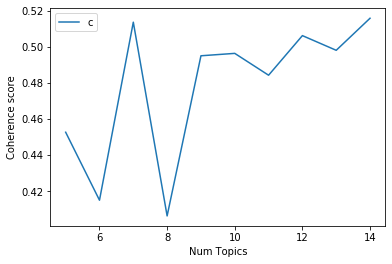

In [27]:
x = range(5, 15, 1)
plt.plot(x, coherence_values)
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.legend(('coherence_values'), loc='best')
plt.show()

Aquí encontramos que los números de topics con mayor coherencia son 7 y 14, veamos por qué y en qué se diferencia el modelo de 7 topics del entrenamiento anterior.

In [28]:
model_list[2].show_topics()

[(0,
  '0.011*"season" + 0.010*"like" + 0.009*"good" + 0.008*"great" + 0.008*"series" + 0.006*"love" + 0.006*"pedal" + 0.006*"story" + 0.005*"watch" + 0.005*"characters"'),
 (1,
  '0.012*"use" + 0.008*"like" + 0.007*"product" + 0.007*"good" + 0.007*"great" + 0.006*"easy" + 0.006*"time" + 0.005*"car" + 0.005*"water" + 0.005*"works"'),
 (2,
  '0.024*"guitar" + 0.014*"sound" + 0.013*"strings" + 0.013*"great" + 0.011*"good" + 0.011*"like" + 0.011*"use" + 0.008*"price" + 0.007*"ve" + 0.006*"string"'),
 (3,
  '0.021*"trap" + 0.011*"traps" + 0.010*"mouse" + 0.007*"bait" + 0.007*"set" + 0.007*"mice" + 0.007*"product" + 0.007*"deer" + 0.007*"like" + 0.006*"house"'),
 (4,
  '0.045*"feeder" + 0.022*"birds" + 0.016*"seed" + 0.015*"bird" + 0.013*"feeders" + 0.010*"squirrels" + 0.009*"water" + 0.009*"seeds" + 0.009*"like" + 0.006*"hummingbird"'),
 (5,
  '0.025*"album" + 0.013*"song" + 0.013*"like" + 0.011*"songs" + 0.009*"music" + 0.008*"good" + 0.007*"great" + 0.007*"cd" + 0.007*"best" + 0.006*"lov

Ahora nos encontramos unas cuantas diferencias con respecto al anterior entrenamiento.

En el topic 0 se ha introducido la palabra "pedal" que debería estar en instrumentos musicales y este es un topic en el que parece que se habla de las series de Amazon Instant Video

El topic 1 tiene la palabra "car" pero no parece que haga referencia a ningún tema específico de los datasets de origen. En general queda un topic bastante genérico que parece hacer referencia a reviews positivas.

Los topics 5 y 6 podrían estar hablando de lo mismo.

Respecto al dataset de Patio Lawn and Garden, tenemos 2 topics que parecen distinguirse bastante bien dentro de este dataset:<br>
· El topic 3 habla de trampas para mantener alejados a los animales salvajes.<br>
· El topic 4 habla de mascotas (más concretamente de pájaros) y jardinería.<br>

In [31]:
model_list[9].show_topics(14)

[(0,
  '0.022*"pedal" + 0.022*"amp" + 0.011*"use" + 0.011*"sound" + 0.010*"pedals" + 0.010*"like" + 0.009*"tone" + 0.008*"great" + 0.007*"good" + 0.007*"tube"'),
 (1,
  '0.033*"trap" + 0.017*"traps" + 0.015*"mouse" + 0.012*"bait" + 0.012*"mice" + 0.011*"set" + 0.008*"house" + 0.007*"ve" + 0.007*"like" + 0.006*"work"'),
 (2,
  '0.014*"love" + 0.008*"elton" + 0.006*"john" + 0.006*"time" + 0.006*"life" + 0.005*"tori" + 0.005*"world" + 0.004*"american" + 0.004*"michael" + 0.004*"jackson"'),
 (3,
  '0.013*"use" + 0.012*"product" + 0.009*"like" + 0.008*"plants" + 0.008*"garden" + 0.006*"easy" + 0.006*"oil" + 0.006*"yard" + 0.006*"plant" + 0.006*"work"'),
 (4,
  '0.031*"season" + 0.017*"series" + 0.017*"like" + 0.016*"great" + 0.014*"love" + 0.013*"watch" + 0.013*"good" + 0.011*"characters" + 0.011*"episode" + 0.011*"watching"'),
 (5,
  '0.012*"story" + 0.012*"movie" + 0.012*"film" + 0.010*"good" + 0.009*"like" + 0.006*"people" + 0.005*"acting" + 0.005*"way" + 0.005*"great" + 0.004*"series"')

El modelo de 14 topics parece sin duda el más acertado.

El topic 0 parece hablar de accesorios para instrumentos musicales.<br>
El topic 12 parece que habla de instrumentos musicales.

El topic 1 habla sin duda de trampas para mantener el hogar libre de animales salvajes (Patio Lawn and Garden).<br>
El topic 3 habla del jardín y muy posiblemente de jardinería.<br>
El topic 8 parece enfocarse en posibles accesorios para el patio.<br>
El topic 11 parece hablar de mangueras concretamente (hose, water, pressure, cable...).<br>
El topic 13 parece que habla de mascotas o de suplementos y comida para estas.

El topic 2 habla de hits musicales (Digital Music).<br>
El topic 6 parece hablar de Digital Music en general.<br>
El topic 10 podría estar centrado en un mismo género musical (rap).<br>
El topic 9 podría estar hablando de lo mismo que el 6 aunque con un mayor enfoque en los grupos musicales.

El topic 4 habla de las series de Amazon Instant Video.<br>
El topic 5 parece que se enfoca más en las películas de Amazon Instant Video.

El topic 7 podría apuntar a Automotive (parece que a los modelos en general les cuesta reconocer este dataset).

En general tenemos un modelo que apunta muy bien a los datasets de origen y que parece distinguir varios subtopics de una manera bastante coherente y con suficiente claridad.

In [38]:
# Me guardo el modelo para no perderlo por accidente y poder seguir trabajando con él.
#model_list[9].save("model14/ldamodel")

In [39]:
# Cargo el modelo
model14 = LdaModel.load("model14/ldamodel")

Veamos ahora si estos topics se corresponden con los topics que asigné originalmente al corpus en base a los dataset de procedencia.

In [41]:
def format_topics_sentences(ldamodel, corpus, texts, original_topic):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    # Add original topic to the end of the output
    contents = pd.Series(original_topic)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Le paso a la función el texto original y el topic original añadiendo el parámetro "original_topic" para comparar y ver cuánto se corresponde éste con los topics encontrados por el modelo

In [42]:
# Primero seteo los índices del corpus original de acuerdo al orden actual (con el que se ha entrenado el modelo)
reviews.index = range(len(reviews))

df_topic_sents_keywords = format_topics_sentences(ldamodel=model14, corpus=corpus_simple,
                                                  texts=reviews.reviewText, original_topic=reviews.topic)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_Topic']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_Topic
0,0,5.0,0.3463,"story, movie, film, good, like, people, acting...",This is one of those items that you keep for '...,2
1,1,7.0,0.5684,"car, use, product, good, like, great, light, t...","These fit all 194 bulb applications, and for c...",2
2,2,12.0,0.6337,"guitar, good, great, use, battery, strings, li...","I ordered them because they are carbon fiber, ...",4
3,3,12.0,0.7598,"guitar, good, great, use, battery, strings, li...",I use this boom attached to a desk clamp to ho...,4
4,4,6.0,0.7214,"album, song, like, songs, cd, good, best, grea...",The songs on this album are really soft and lo...,3
...,...,...,...,...,...,...
49976,49976,12.0,0.4224,"guitar, good, great, use, battery, strings, li...",Well thought out unit that does what it says i...,4
49977,49977,6.0,0.7135,"album, song, like, songs, cd, good, best, grea...",When Taylor Swift announced her new album in m...,3
49978,49978,4.0,0.7234,"season, series, like, great, love, watch, good...",Very funny. If you have ever watched or read ...,1
49979,49979,3.0,0.4461,"use, product, like, plants, garden, easy, oil,...","For years, I lived with a Black & Decker trimm...",5


Según lo visto en nuestro análisis, los topics 4 y 5 deberían hacer referencia principalmente al primer dataset (Amazon Instant Video).

In [48]:
df_dominant_topic.Dominant_Topic[df_dominant_topic.Original_Topic == 1].value_counts()

4.0     6334
5.0     2739
6.0      419
2.0      258
11.0      49
9.0       47
12.0      35
8.0       31
7.0       21
1.0       19
10.0      16
3.0       15
0.0       12
13.0       5
Name: Dominant_Topic, dtype: int64

Efectivamente podemos comprobar que la inmensa mayoría cumplen con lo predicho.

Veamos si se cumple también para el resto de topics, Automotive (dataset 2) estaba bastante difícil.

In [49]:
df_dominant_topic.Dominant_Topic[df_dominant_topic.Original_Topic == 2].value_counts()

7.0     4533
12.0    2126
3.0     1113
8.0      973
11.0     655
0.0      441
4.0       55
1.0       40
5.0       22
6.0       15
10.0      10
2.0        7
9.0        4
13.0       3
Name: Dominant_Topic, dtype: int64

Tal como parecía, el dataset 7 parece apuntar a automotive, aunque no lo hace demasiado bien

In [50]:
df_dominant_topic.Dominant_Topic[df_dominant_topic.Original_Topic == 3].value_counts()

6.0     8134
9.0     1517
2.0       95
13.0      74
4.0       57
10.0      46
5.0       27
12.0      20
11.0      11
0.0        7
3.0        4
7.0        3
8.0        3
1.0        2
Name: Dominant_Topic, dtype: int64

El dataset de Digital Music (3) queda claramente representado por los topics 6 y 9 tal y como pudimos ver en nuestro análisis.

In [51]:
df_dominant_topic.Dominant_Topic[df_dominant_topic.Original_Topic == 4].value_counts()

12.0    7082
0.0     1686
7.0      268
9.0      251
3.0      246
11.0     197
8.0      102
4.0       60
6.0       48
5.0       27
1.0       11
2.0       10
10.0       3
13.0       2
Name: Dominant_Topic, dtype: int64

El dataset de Musical Instruments también queda representado por los topics 12 y 0 que dijimos que hacían referencia uno a los instrumentos y otro a sus accesorios.

In [52]:
df_dominant_topic.Dominant_Topic[df_dominant_topic.Original_Topic == 5].value_counts()

3.0     3242
1.0     1626
8.0     1197
13.0    1155
12.0     919
11.0     878
7.0      867
4.0       46
0.0       27
5.0       15
6.0        8
9.0        6
2.0        5
Name: Dominant_Topic, dtype: int64

Aquí también se cumplen las expectativas. Aunque el topic 12, que habla de instrumentos musicales, abunda más que el topic 11, que parecía hablar específicamente de mangueras. En cualquier caso se demuestra lo que llevábamos viendo desde el principio, que el tema del patio/jardín es el que parece contener un mayor número de subtopics.

¿Qué habrá sido de los topics 2, 10 y 11? No parece que tengan mucha presencia en general, veamos de qué datasets originales son más representativos cada uno de ellos.

In [53]:
df_dominant_topic.Original_Topic[df_dominant_topic.Dominant_Topic == 2].value_counts()

1    258
3     95
4     10
2      7
5      5
Name: Original_Topic, dtype: int64

El topic 2 dijimos que habla de Digital Music, pero tiene su mayor presencia en Amazon Instant Video. ¿Tal vez por los videoclips o conciertos? Parecía estar enfocado en nombres de cantantes famosos.

In [54]:
df_dominant_topic.Original_Topic[df_dominant_topic.Dominant_Topic == 10].value_counts()

3    46
1    16
2    10
4     3
Name: Original_Topic, dtype: int64

El topic 10 dijimos que hablaba del género rap en Digital Music. Es un topic que aparece muy poquito así que podría tener todo el sentido del mundo que se trate de algo tan específico.

In [55]:
df_dominant_topic.Original_Topic[df_dominant_topic.Dominant_Topic == 11].value_counts()

5    878
2    655
4    197
1     49
3     11
Name: Original_Topic, dtype: int64

El topic 11 dijimos que habla de mangueras, y aunque el dataset 5 (patio y jardín) es en el que más aparece, no le saca mucha diferencia al 2º dataset (Automotive).

En general, y como conclusión final, diría que se trata de un modelo bastante bueno para detectar topics dentro de todos estos temas que hemos estado viendo, salvando su torpeza al identificar temas relacionados con la automoción ~~y las mangueras~~, donde parece fallar bastante.

Para terminar me voy a guardar una visualización de los topics

In [62]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model14, corpus_simple, dictionary_simple)
pyLDAvis.save_html(vis, 'lda_topics_amazon.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.196532  0.011078       1        1  20.841883
12     0.122625  0.015634       2        1  11.156214
9     -0.141935  0.007259       3        1   9.184222
3      0.161854 -0.014090       4        1   8.966863
7      0.145542 -0.002035       5        1   8.247377
4     -0.091156 -0.129098       6        1   6.334674
5     -0.128074 -0.135097       7        1   6.004634
8      0.128139  0.020320       8        1   5.815836
11     0.101560 -0.032203       9        1   5.767617
0      0.095293  0.034198      10        1   4.324825
1      0.104776 -0.032435      11        1   4.098246
13     0.063180  0.045955      12        1   3.827627
2     -0.211255 -0.089494      13        1   3.722932
10    -0.154018  0.300009      14        1   1.707053, topic_info=        Term          Freq         Total Category  logprob  loglift
1958    quot  17581.000000  17581.000000  Default  30.0000  30.0000
97     album  23812.000000  23812.000000  Default  29.0000  29.0000
152     song  12113.000000  12113.000000  Default  28.0000  28.0000
282   season   5542.000000   5542.000000  Default  27.0000  27.0000
1052  feeder   4011.000000   4011.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
7       like    278.601898  28474.250000  Topic14  -5.1251  -0.5566
2244   tight    185.906799   1214.974854  Topic14  -5.5297   2.1932
250     nice    219.775925   6380.439941  Topic14  -5.3623   0.7020
20     great    197.860672  19878.505859  Topic14  -5.4674  -0.5394
1459      lp    157.619949    648.423035  Topic14  -5.6947   2.6560

[1115 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
12635     11  0.996030           aa
3801       1  0.011873           ac
3801       2  0.955784           ac
3801       3  0.029683           ac
10756      8  0.993447  accessories
...      ...       ...          ...
3002       1  0.051637       zombie
3002       7  0.935925       zombie
3002       8  0.006455       zombie
7249       1  0.020824      zombies
7249       7  0.971781      zombies

[3896 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 13, 10, 4, 8, 5, 6, 9, 12, 1, 2, 14, 3, 11])

Aquí podemos ver algo muy interesante, y es como los topics 1 y 3 (que parecen corresponderse con los topics 6 y 9 del modelo) están emparejados al igual que los topics 7 y 8 (que parecen corresponderse con los topics 4 y 5 del modelo). Dos topics para Digital Music (canciones / grupos o estilos) y dos topics para Amazon Instant Video (series / películas), y entre medias tenemos al topic que hablaba de cantantes famosos y que parece estar definido también por palabras que indican un género o subgénero cinematográfico.